# Don't trust boxplot

- toc: true 
- badges: true
- comments: false
- categories: [r,ggplot,recipes]


*TOC*
* write a function for generating data
* use melt for rearranging data
* create a base plot 
* add a boxplot to the base plot
* add a jiiter plot to the base plot
* create a figure for explaining the box plot (the fun part of this post)
* create another dataset 
* add boxplot + jiiter plot
* what's happening?

 



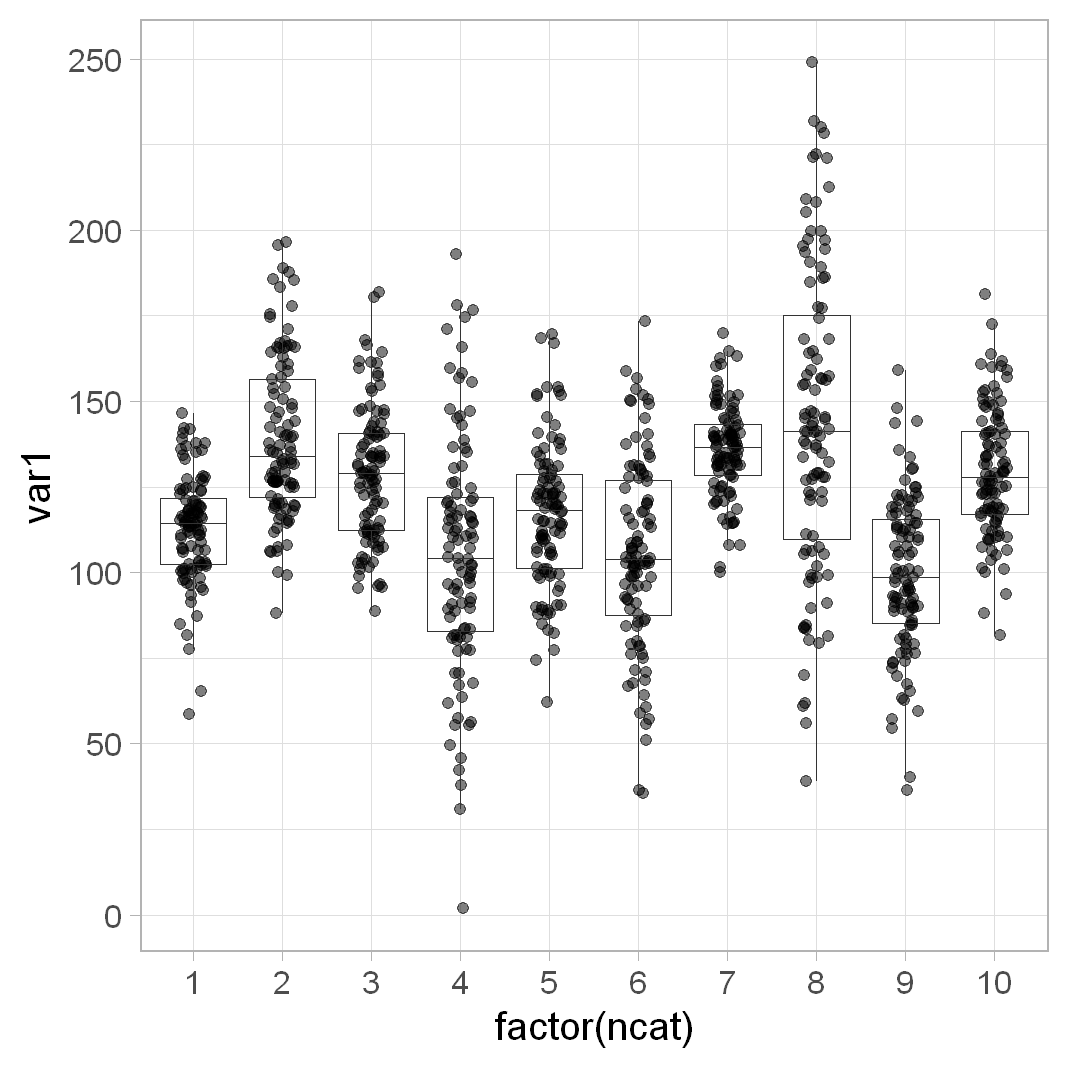

In [3]:

#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
#  loading required libraries for this notebook
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

#loading libraries


library(ggplot2)
library(gridExtra)
library(data.table)
library(RColorBrewer)
library(ggpubr)
library(rstatix, warn.conflicts = FALSE)
library(ggrepel)
library(ggpubr)
library(patchwork)
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
#	creating a function for generating a dataset
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

# function for generating data with custom number of rows, means and sds

simpleDataset <- function(number_of_rows,means,sds)
{
l <- length(means)
res <- lapply(seq(1:l),function(x) 
	   eval(
	   parse(
	   text=paste("rnorm(",number_of_rows,",",means[x],",",sds[x],")",sep=""))
	   )
	   ) 
dat <- data.frame((sapply(res,c)))
id <- rownames(dat)
dat <-  cbind(id=id,dat)
dt <- data.table(dat)
return(dt)
}


dat1 <- simpleDataset(number_of_rows=100,
					  means=runif(10,100,150),
				      sds=runif(10,10,40))
outliers <- simpleDataset(number_of_rows=5,
					  means=runif(10,60,80),
				      sds=runif(10,10,10))				  
dato     <-rbind(dat1,outliers) 
dt.melt <- melt(dat1, id.vars="id")
colnames(dt.melt) <- c("id","category","var1")
dt.melt$ncat <- as.numeric(dt.melt$category)


#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
#	Jiitter plots + boxplot + brackets 
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

#setting up dimensions
options(repr.plot.width=8.9, repr.plot.height=8.9,units="cm")

#adding jiitter plot
p <-  ggplot(dt.melt,aes(x=factor(ncat),y=var1))        +
      geom_jitter(position = position_jitter(0.15),alpha=0.5,size = 3) +
      geom_boxplot(alpha = 0,lwd=0.2) + theme_minimal(base_size =24)

p +theme_light(base_size=24)

So for now everything on track. We created a dataset using a custom function. 10 variables with 100 points each and them we plot them using scatter plots. Before plotting a few more data we need to answer the question
*How are boxplot constructed?* (*warning*: shameless self-promotion ahead) First of all you can check on my book/ebook [https://amzn.com/B08W8W5WSF](https://amzn.com/B08W8W5WSF) 
Now it starts the fun part we will recreate a plot on the anatomy of a boxplot (see [here](https://www.sharpsightlabs.com/blog/ggplot-boxplot/)) using ggplot. 
 





ymin,lower,middle,upper,ymax,outliers,notchupper,notchlower,x,flipped_aes,...,xid,newx,new_width,weight,colour,fill,size,alpha,shape,linetype
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>,<dbl>,<dbl>,<dbl>,<lgl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<chr>
27.14312,61.85538,74.33114,93.25041,127.1763,155,79.19523,69.46705,0,FALSE,...,1,0,1,1,grey20,white,2,NA,19,solid


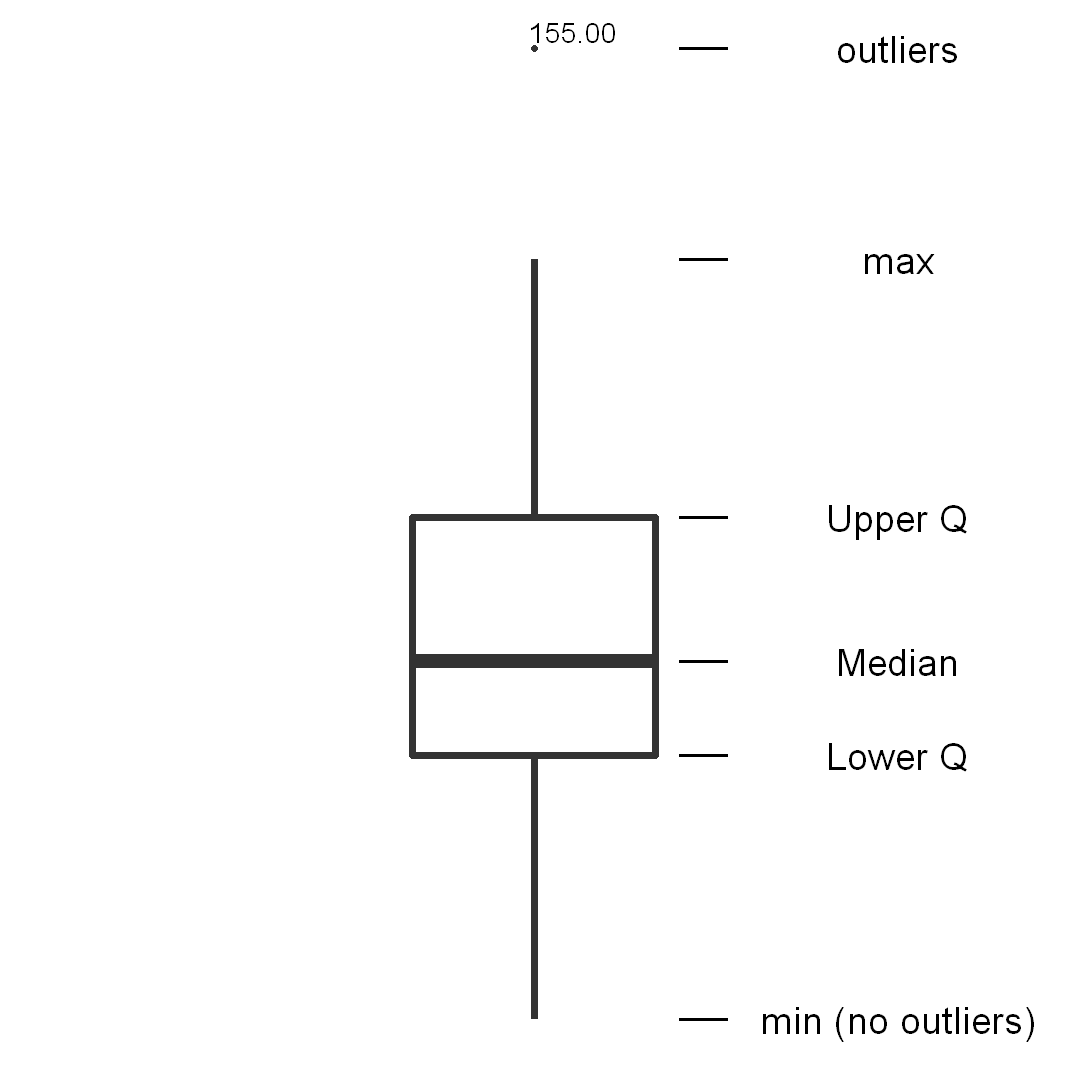

In [4]:
# we create a dataset and add a few outliers
# 
y   <- c(60,63,105,155,rnorm(100,80,25))
box <-  ggplot()                                               +
        theme_void()                                           +
        geom_boxplot(aes(x=0,y=y),width=1,notch = FALSE,lwd=2) +  
        theme(legend.position = "none")                        +
        lims(x=c(-2,2))
      
#how can we  get out data? using the function ggplot_build()
#need to change it to a data.frame and rename cols

box_data <- (ggplot_build(box)$data)[[1]]
box_data
bdata <- data.frame(t(box_data[c(1,2,3,4,5,14)]))
colnames(bdata) <- c("y")
#we need to transpose the data and convert them to a data frame
#now we extract the ourliers 
outl  <- data.frame(box_data$outliers)
colnames(outl)  <- c("outl")

#now that I got the data I plot everything with labels
p2 <- box + geom_text (data=bdata,aes(
                      x=1.5,
                      y=y,
                      label = c("min (no outliers)","Lower Q","Median","Upper Q","max","outliers")),size=8)    +
                      geom_segment(data=bdata, aes(x = 0.8, y = y, xend = 0.6, yend =y),lwd=1)  
                        





	                                                                                  
#since we have created the dataset WITH outliers we include labels also for them
#if your dataset has no outliers you need to commet this part out
	
p2 + geom_text_repel(data=outl,aes(x=0.1, y=outl,label=format(round(outl, 2), nsmall = 2)),size=6) 



*notes on the code:* we create our variable `y` with `rnorm` and we add a few outliers by hand then we create the boxplot
with an empty theme using `theme_void()`. The funny part start when we ask ggplot to show how the plot was built with the 
`ggplot_build`. We then need to rotate (`t`) the selected columns `c(1,2,3,4,5,14)` ,convert the results into a `data.frame`,
rename the columns (`colnames`) and then use them (our `y`) to add labvels to our plot using `geom_text` 


So the bound of the box refers to *upper* and *lower quartile*. The lower quartile splits off the lowest 25% of the data (also called 25% percentile) while the third quartile splits off the highest 25% of data from the lowest 75% (75% percentile). 
But **what is a quartile**?
when a set of _n_ measurements of the variable _x_ has been arranged in order of magnitude the _pth percentile_ is the value of _x_ greater than _p_ of the measurements.
The 25th and 75th percentile are called the lower and upper quartiles and the 50th percentile is the median of the dataset. the IQR interquartile range (IQR) for a set of measurement is the difference between the upper and lower quartile



Another representation of boxplot can also include *notch*. the default is not to visualuize them but just adding `notch=true` to the previous plot we will do the trick

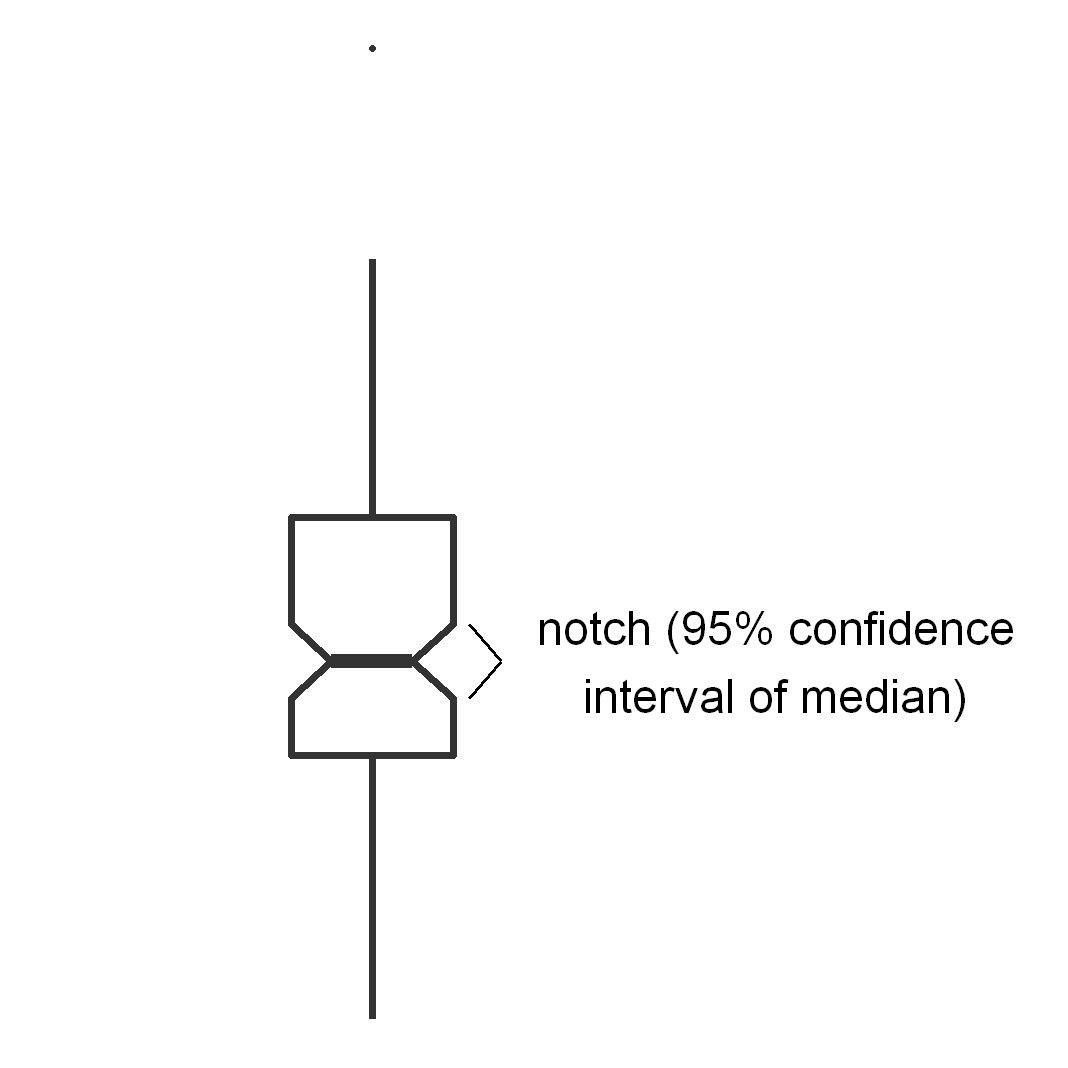

In [5]:
boxnotch <-  ggplot()                                               +
             theme_void()                                           +
             geom_boxplot(aes(x=0,y=y),width=1,notch = TRUE,lwd=2)  +  
             theme(legend.position = "none")                        +
             lims(x=c(-2,4))
notchdata <- data.frame(t(box_data[c(7,8)]))
colnames(notchdata) <- c("y_notch")
#we need to transpose the data and convert them to a data frame

#now that I got the data I plot everything with labels
p3 <- boxnotch +  geom_segment(data=notchdata, aes(x = 0.8, 
                                                   y = mean(y_notch),
                                                   xend = 0.6, yend = y_notch
                                                   ),lwd=1)
p4 <- p3 + annotate(geom="text", x=2.5, y= mean(notchdata$y_notch),
                    label="notch (95% confidence\ninterval of median)",size=10)
p4

so having a look at the the [page](https://www.autodesk.com/research/publications/same-stats-different-graphs) we can see that
the following case can happen. we will load the dataset from the `datasauRus` package

# What's happening?

      left              lines               normal          right       
 Min.   :-9.76964   Min.   :-9.769575   Min.   :-9.76   Min.   :-9.760  
 1st Qu.:-2.68999   1st Qu.:-2.689993   1st Qu.:-2.68   1st Qu.:-2.680  
 Median :-0.00999   Median :-0.007132   Median : 0.00   Median : 0.000  
 Mean   :-1.17780   Mean   :-0.831733   Mean   : 0.00   Mean   : 1.174  
 3rd Qu.: 2.67007   3rd Qu.: 2.670236   3rd Qu.: 2.68   3rd Qu.: 2.680  
 Max.   : 9.75025   Max.   : 9.756001   Max.   : 9.76   Max.   : 9.760  
     split          
 Min.   :-9.769886  
 1st Qu.:-2.689989  
 Median :-0.003099  
 Mean   :-0.003060  
 3rd Qu.: 2.680000  
 Max.   : 9.760000  

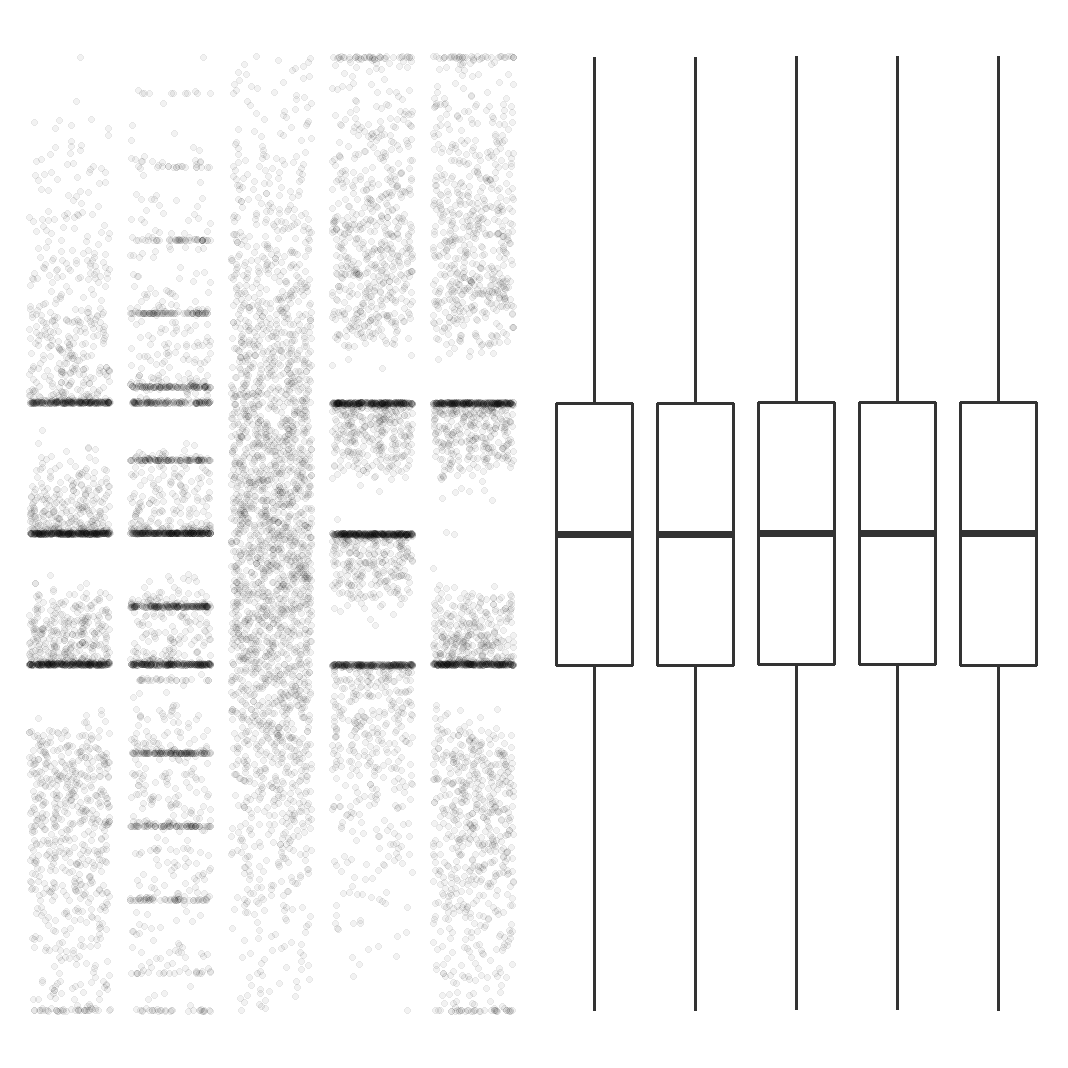

In [6]:
options(repr.plot.width=8.9, repr.plot.height=8.9,units="cm")
library(datasauRus)
summary(box_plots)

p1 <-ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_jitter(alpha=0.05)                                 +
theme_void()  

p2 <- ggplot(stack(box_plots), aes(x = ind, y = values))+
geom_boxplot(lwd=1) +
theme_void()  
p1+p2



# Solutions?
We can see that plotting the **raw** points even for hundreds of points works and represent well our data. In this case adding notch does not solve the problem. Other kind of plot get not fooled by our data as it can be seen in the following figure

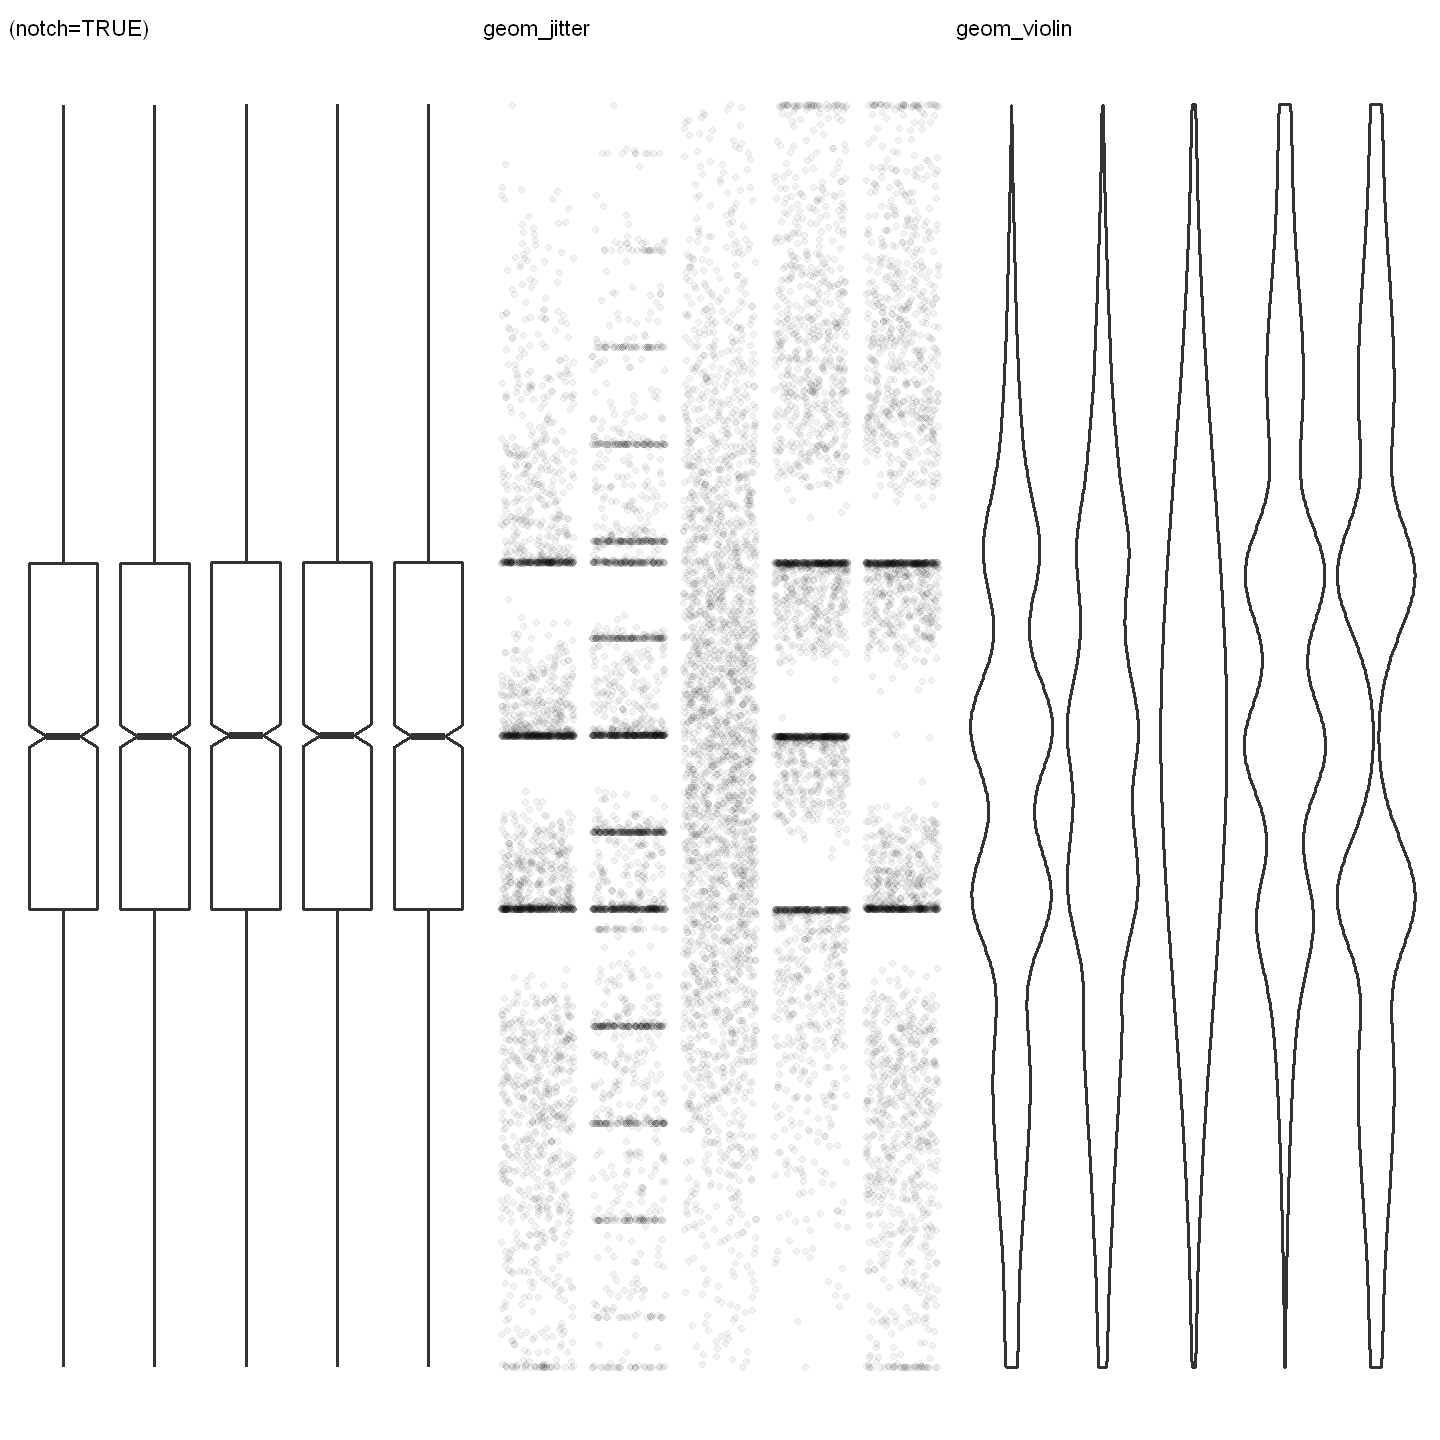

In [6]:
options(repr.plot.width=12, repr.plot.height=12)
pnotch <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_boxplot(notch=TRUE,lwd=1)  +  ggtitle("(notch=TRUE)") +
theme_void()
  
pjitter <-ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_jitter(alpha=0.05)	 +  ggtitle("geom_jitter") +								   
theme_void()  

pviolin <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_violin(lwd=1)  +  ggtitle("geom_violin") +
theme_void()  

pnotch + pjitter + pviolin

# Other packages 
1. beeswarm plot ggbeeswarm [https://github.com/eclarke/ggbeeswarm] (and here the things start getting artistic too!) (note: not all representation for this dataset work due to the number of points)

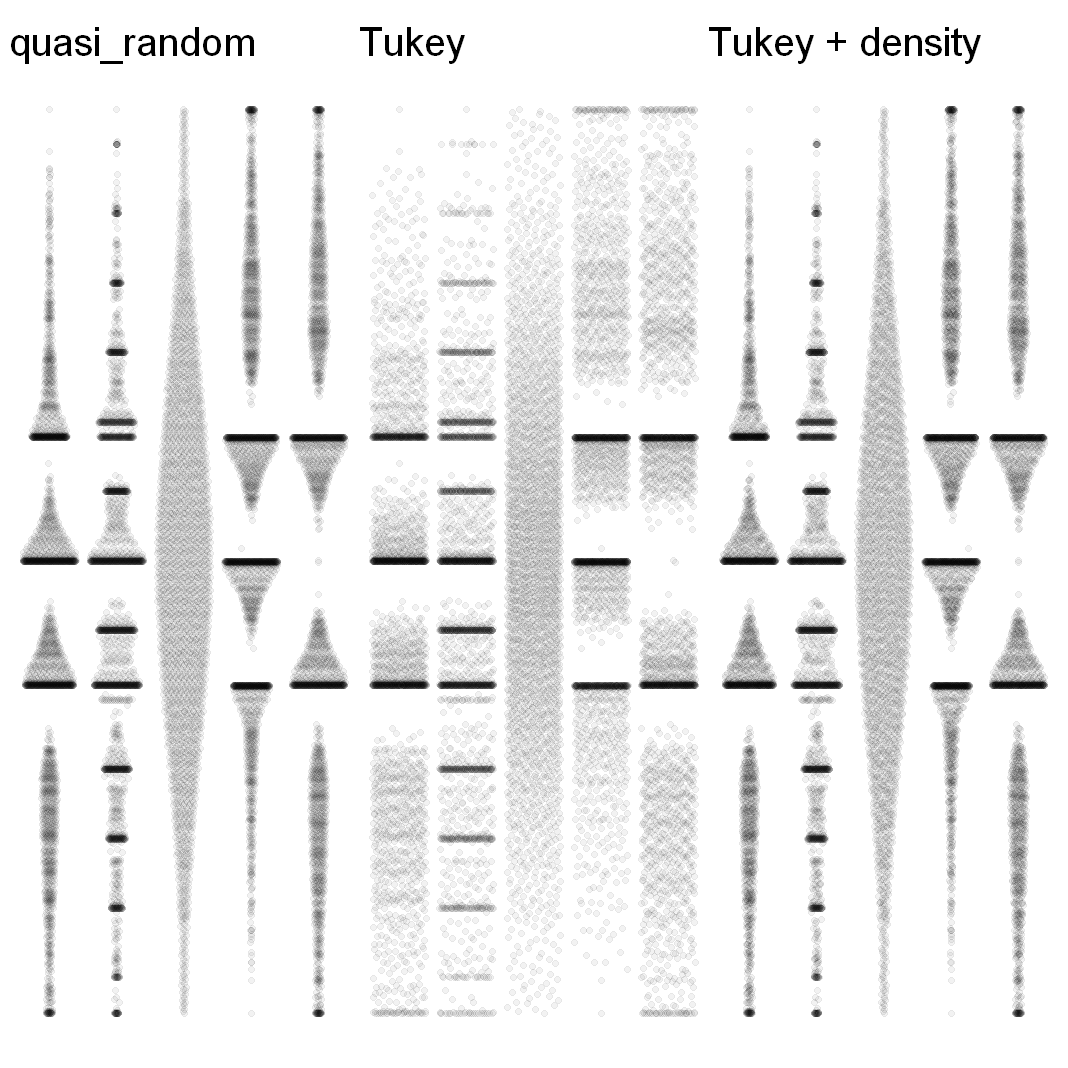

In [7]:
library(ggbeeswarm)

p_qrandom0 <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_quasirandom(alpha=0.05)  +  ggtitle("quasi_random") +
theme_void(base_size=20)

#p_qrandom0

p_qrandom1 <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_quasirandom(alpha=0.05,method = "tukey")  +  ggtitle("Tukey") +
theme_void(base_size=20)

#p_qrandom1

p_qrandom2 <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_quasirandom(alpha=0.05,method = "tukeyDense")   +  ggtitle("Tukey + density") +
theme_void(base_size=20)

#p_qrandom2

p_qrandom3 <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_quasirandom(alpha=0.05,method = "tukeyDense")   +  ggtitle("Banded frowns") +
theme_void(base_size=20)

#p_qrandom3

p_qrandom4 <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_quasirandom(alpha=0.05,method = "frowney")   +  ggtitle("Banded smiles") +
theme_void(base_size=20)

#p_qrandom4

#too many points
#p_beeswarm <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
#geom_beeswarm(alpha=0.05) +  ggtitle("beeswarm") +
#theme_void() 

p_qrandom0 + p_qrandom1+p_qrandom2






you can halso mix plot a useful package for that is `gghalves` that you can find [here](https://cran.r-project.org/web/packages/gghalves/vignettes/gghalves.html)

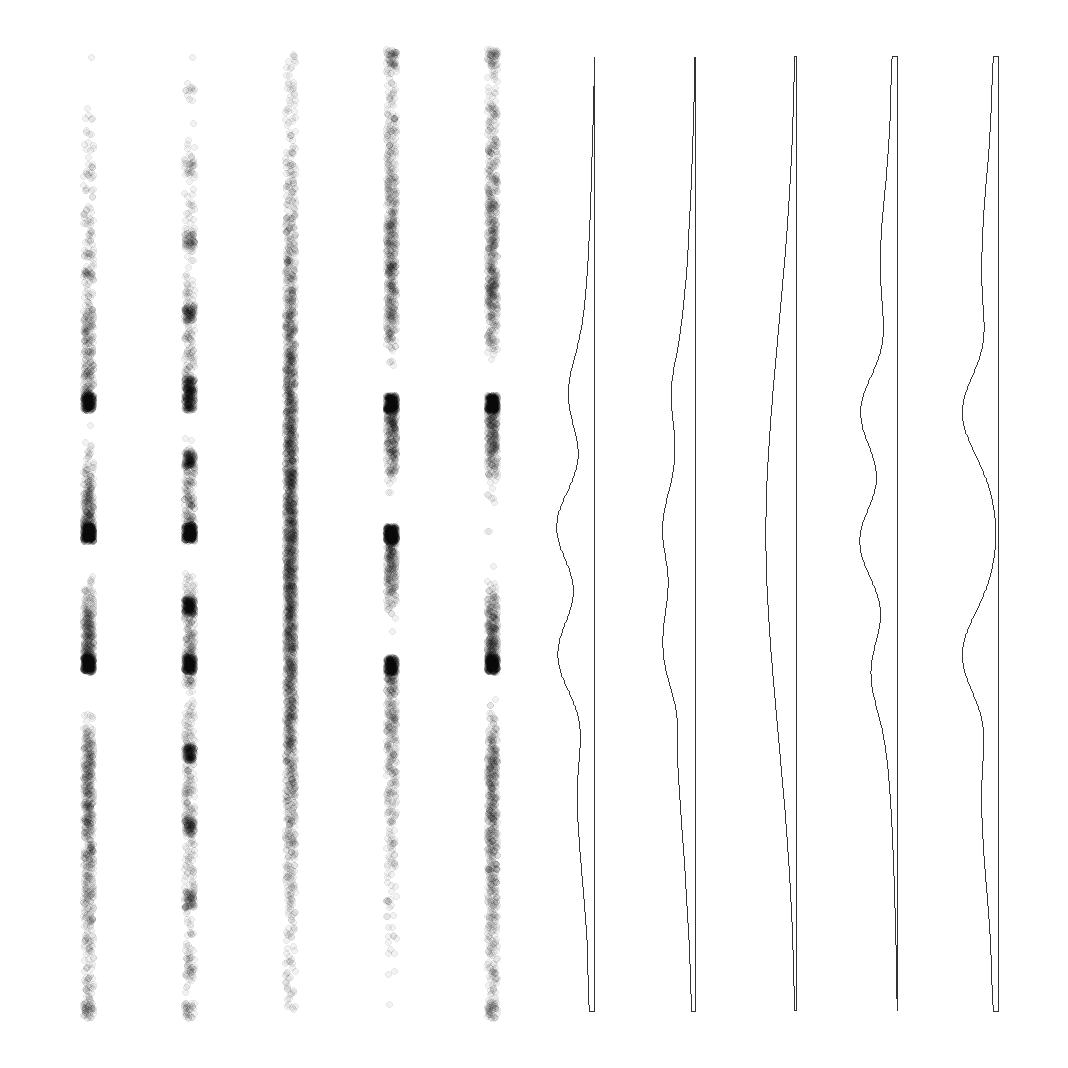

In [8]:
library(gghalves)

point_half <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_half_point(alpha=0.05) +theme_void(base_size=20)

violin_half <- ggplot(stack(box_plots), aes(x = ind, y = values)) +
geom_half_violin() +theme_void(base_size=20)

point_half + violin_half

finally a very useful package, also my favorite one for EDA `ggstatplot`that you can find [here](https://indrajeetpatil.github.io/ggstatsplot/) that calculate also a lot of useful stats and combine different kind of plot in one plot

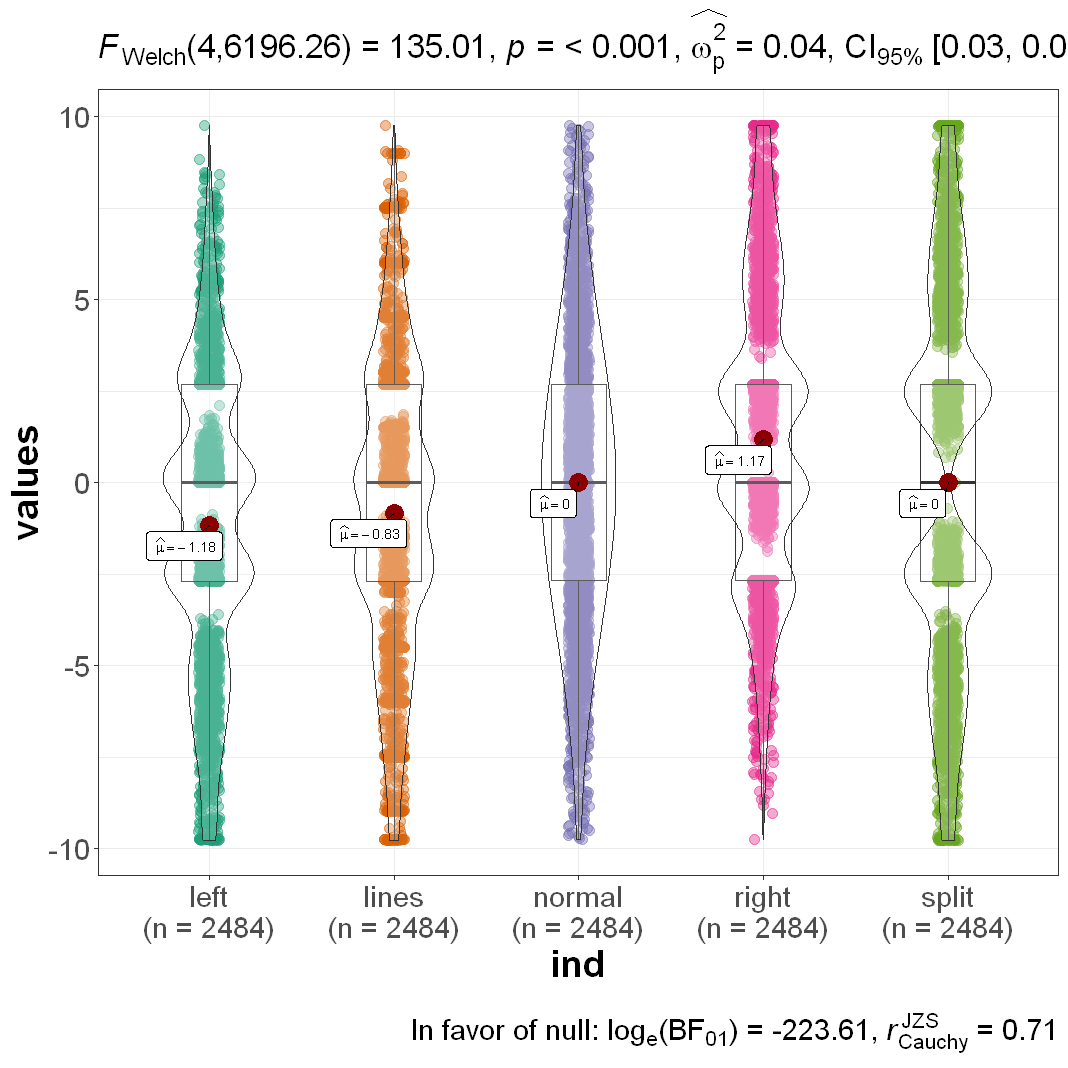

In [10]:
library(ggstatsplot)

stackbox <- stack(box_plots)

pstack  <- ggbetweenstats(
  data = stackbox,
  x = ind,
  y = values,
)
pstack +  theme(text = element_text(size = 22),
          plot.subtitle = element_text(size = 20),
          legend.title = element_text(size = 22),
          legend.text = element_text(size = 22)) 
